# DRL_PFOpt Model Training
#### 2022/11/03, AJ Zerouali

This notebook trains TD3 and SAC models in the *DRL_PFOpt* framework. We give details on the models' parameters here, and the objective is to have a database of trained models for future tests and experiments.


## Dow Jones Data

In [12]:
# Kill warnings
from warnings import filterwarnings
filterwarnings("ignore")

### Basics
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.use('Agg')
%matplotlib inline
import datetime
import itertools

### OpenAI Gym and StableBaselines3
from gym.utils import seeding
import gym
from gym import spaces
from stable_baselines3.common.vec_env import DummyVecEnv

### What is this?
import sys
sys.path.append("../FinRL")


### My imports (22/10/31, AJ Zerouali)
#### NOTE: Update when trials are over
'''
    Update submodules
'''
import DRL_PFOpt_Utils
#import DRL_PFOpt_Agent_temp
#from DRL_PFOpt_Agent_temp import PFOpt_DRL_Agent
import DRL_PFOpt_Agent
from DRL_PFOpt_Agent import PFOpt_DRL_Agent
import DRL_PFOpt_Data
import DRL_PFOpt_gymEnv


# Load Dow Jones data
df_file = pd.read_csv(filepath_or_buffer="datasets/DJIA30_data_0801-0908.csv",
                           usecols = ['date', 'open', 'high', 'low', 'close', 'volume', 'tic'])

# Instantiate feature engineering object
FeatureEng = DRL_PFOpt_Data.FeatureEngineer(tech_indicator_list = ["turbulence"],
                                                 use_return_covs = True,
                                                 n_lookback_prds = 90)

# Preprocess df_file
df_X, np_close_returns, np_returns_cov = FeatureEng.preprocess_data(df_X = df_file)

Successfully computed asset returns and their covariances
Successfully added technical indicators
Successfully added turbulence index


In [13]:
# Train and test dates
start_train_date = '2008-12-31'
end_train_date = '2020-07-01'
start_test_date = end_train_date
end_test_date = '2021-09-02'

In [14]:
df_train, ret_X_train, cov_X_train = DRL_PFOpt_Data.data_split(df_X = df_X, 
                                                                    start=start_train_date, 
                                                                    end = end_train_date,
                                                                    use_returns_cov = True,
                                                                    ret_X= np_close_returns,
                                                                    cov_X=np_returns_cov)

Dataframe, returns and cov have same number of dates


In [15]:
df_test, ret_X_test, cov_X_test = DRL_PFOpt_Data.data_split(df_X = df_X, 
                                                                    start=start_test_date, 
                                                                    end = end_test_date,
                                                                    use_returns_cov = True,
                                                                    ret_X= np_close_returns,
                                                                    cov_X=np_returns_cov)

Dataframe, returns and cov have same number of dates


**Get benchmark data**

Benchmark data (DJIA) over testing dates.

In [5]:
df_DJI_benchmark, df_DJI_returns = DRL_PFOpt_Utils.get_benchmark_prices_and_returns(
                    ticker = "^DJI", start_date = '2020-07-01', end_date = '2021-09-02')

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (296, 8)


## TD3 - Case 1

Here the state features are the OHLCV data with the network actions.

**Environments**

In [6]:
# Env params
n_lookback_prds = 90
pf_value_ini = 1000000
reward_type= 'portfolio_return'
state_struct_list = ['open','high','low','close', 'volume', 'actions']
tech_ind_list = []
transaction_cost_pct = 0

In [7]:
gym_train_env = DRL_PFOpt_gymEnv.PortfolioOptEnv(
            df_X = df_train,
            cov_X = cov_X_train,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,)

In [8]:
gym_test_env = DRL_PFOpt_gymEnv.PortfolioOptEnv(
            df_X = df_test,
            cov_X = cov_X_test,
            n_lookback_prds = 90,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,)

In [9]:
gym_train_env.N_periods

2894

**Model**

**Comment (22/11/02):** Let's start by training the model for 200 episodes over the training period of 2894 days.

In [10]:
# Instantiate agent
TD3_Agent = PFOpt_DRL_Agent(train_env = gym_train_env)

In [11]:
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}
TD3_Agent.set_model(model_name = "td3",
                    model_kwargs=TD3_PARAMS)
TD3_Agent.train_model(tb_log_name='td3',
                      n_train_rounds=200)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
td3 with given parameters has been successfully created.


KeyboardInterrupt: 

In [ ]:
TD3_Agent.save_model(model_fname = "trained_models/TD3_OHLCVA_2211022144")

In [ ]:
df_pf_value_hist, df_pf_return_hist, \
df_pf_weights_hist = TD3_Agent.run_backtest(test_env = gym_test_env,)

In [ ]:
%matplotlib inline
TD3_Agent.plot_backtest_results(df_benchmark_returns=df_DJI_returns)

In [ ]:
df_pf_weights_hist.plot()

In [ ]:
df_pf_weights_hist.iloc[50:78].plot()

## TD3 - Case 2

Here the state features are the OHLCV data with the network weights.

**Environments**

In [ ]:
# Env params
n_lookback_prds = 90
pf_value_ini = 1000000
reward_type= 'portfolio_return'
state_struct_list = ['open','high','low','close', 'volume', 'weights']
tech_ind_list = []
transaction_cost_pct = 0

In [ ]:
gym_train_env = DRL_PFOpt_gymEnv.PortfolioOptEnv(
            df_X = df_train,
            cov_X = cov_X_train,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,)

In [ ]:
gym_test_env = DRL_PFOpt_gymEnv.PortfolioOptEnv(
            df_X = df_test,
            cov_X = cov_X_test,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,)

In [ ]:
gym_train_env.N_periods

**Model**

**Comment (22/11/02):** Let's start by training the model for 200 episodes over the training period of 2894 days.

In [ ]:
# Instantiate agent
TD3_Agent = PFOpt_DRL_Agent(train_env = gym_train_env)

In [ ]:
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}
TD3_Agent.set_model(model_name = "td3",
                    model_kwargs=TD3_PARAMS)
TD3_Agent.train_model(tb_log_name='td3',
                      n_train_rounds=200)

In [ ]:
TD3_Agent.save_model(model_fname = "trained_models/TD3_OHLCVW_2211022211")

In [ ]:
df_pf_value_hist, df_pf_return_hist, \
df_pf_weights_hist = TD3_Agent.run_backtest(test_env = gym_test_env,)

In [ ]:
%matplotlib inline
TD3_Agent.plot_backtest_results(df_benchmark_returns=df_DJI_returns)

In [ ]:
df_pf_weights_hist.plot()

In [ ]:
df_pf_weights_hist.iloc[50:78].plot()

## TD3 - Case(s) 3


**Environments**

In [ ]:
# Env params
n_lookback_prds = 90
pf_value_ini = 1000000
reward_type= 'portfolio_return'
state_struct_list = ['open','high','low','close', 'volume', 'weights']
tech_ind_list = []
transaction_cost_pct = 0

In [ ]:
gym_train_env = DRL_PFOpt_gymEnv.PortfolioOptEnv(
            df_X = df_train,
            cov_X = cov_X_train,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,)

In [ ]:
gym_test_env = DRL_PFOpt_gymEnv.PortfolioOptEnv(
            df_X = df_test,
            cov_X = cov_X_test,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,)

In [ ]:
gym_train_env.N_periods

**Model**
Tried several combinations of batch size, learning rate, keeping/removing discount factor. The *TD3_PARAMS* second cell below gives the best results.

In [ ]:
# Instantiate agent
TD3_Agent = PFOpt_DRL_Agent(train_env = gym_train_env)

In [ ]:
TD3_PARAMS = {"batch_size": 500, 
              "buffer_size": 10000, 
              "learning_rate": 0.01,
                "gamma":0}
TD3_Agent.set_model(model_name = "td3",
                    model_kwargs=TD3_PARAMS)
TD3_Agent.train_model(tb_log_name='td3',
                      n_train_rounds=20)

In [ ]:
TD3_Agent.save_model(model_fname = "trained_models/TD3_OHLCVW_SR243_2211030155")

In [ ]:
df_pf_value_hist, df_pf_return_hist, \
df_pf_weights_hist = TD3_Agent.run_backtest(test_env = gym_test_env,)

**Best Sharpe ratio I've obtained until now!!**

In [ ]:
%matplotlib inline
TD3_Agent.plot_backtest_results(df_benchmark_returns=df_DJI_returns)

In [ ]:
df_pf_weights_hist.iloc[:60].plot()

## SAC - Case 1

I first tried the TD3 hyperparameters of Case(s) 3 above as a baseline, and SAC just crashed. This case will just be with the original FinRL hyperparams.

**Comment:** Note the huge losses in the training...


**Environments**

In [ ]:
# Env params
n_lookback_prds = 90
pf_value_ini = 1000000
reward_type= 'portfolio_return'
state_struct_list = ['open','high','low','close', 'volume', 'weights']
tech_ind_list = []
transaction_cost_pct = 0

In [ ]:
gym_train_env = DRL_PFOpt_gymEnv.PortfolioOptEnv(
            df_X = df_train,
            cov_X = cov_X_train,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,)

In [ ]:
gym_test_env = DRL_PFOpt_gymEnv.PortfolioOptEnv(
            df_X = df_test,
            cov_X = cov_X_test,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,)

In [ ]:
gym_train_env.N_periods

**Model**

In [ ]:
# Instantiate agent
SAC_Agent = PFOpt_DRL_Agent(train_env = gym_train_env)

In [ ]:
'''SAC_PARAMS = {
    "batch_size": 500,
    "buffer_size": 100000,
    "learning_rate": 0.01,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
    "gamma":0,
}
'''
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}
SAC_Agent.set_model(model_name = "sac",
                    model_kwargs=SAC_PARAMS)
SAC_Agent.train_model(tb_log_name='sac',
                      n_train_rounds=20)

In [ ]:
SAC_Agent.save_model(model_fname = "trained_models/SAC_OHLCVW_????")

In [ ]:
df_pf_value_hist, df_pf_return_hist, \
df_pf_weights_hist = SAC_Agent.run_backtest(test_env = gym_test_env,)

In [ ]:
%matplotlib inline
SAC_Agent.plot_backtest_results(df_benchmark_returns=df_DJI_returns)

In [ ]:
df_pf_weights_hist.plot()

In [ ]:
df_pf_weights_hist.iloc[50:60].plot()

## SAC - Case(s) 2

Tweaking the *SAC_PARAMS* dictionary:

**1) Add *gamma=0* and take a greater learning rate (0.01).**

* Training crashed at the 19-th round because of some issue with torch distributions:

            File /usr/local/lib/python3.9/dist-packages/torch/distributions/normal.py:54, in Normal.__init__(self, loc, scale, validate_args)
             52 else:
             53     batch_shape = self.loc.size()
        ---> 54 super(Normal, self).__init__(batch_shape, validate_args=validate_args)

        File /usr/local/lib/python3.9/dist-packages/torch/distributions/distribution.py:55, in Distribution.__init__(self, batch_shape, event_shape, validate_args)
             53         valid = constraint.check(value)
             54         if not valid.all():
        ---> 55             raise ValueError(
             56                 f"Expected parameter {param} "
             57                 f"({type(value).__name__} of shape {tuple(value.shape)}) "
             58                 f"of distribution {repr(self)} "
             59                 f"to satisfy the constraint {repr(constraint)}, "
             60                 f"but found invalid values:\n{value}"
             61             )
             62 super(Distribution, self).__init__()

        ValueError: Expected parameter loc (Tensor of shape (1, 28)) of distribution Normal(loc: torch.Size([1, 28]), scale: torch.Size([1, 28])) to satisfy the constraint Real(), but found invalid values:
        tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                 nan, nan, nan, nan]], device='cuda:0')

* Rolling back to torch 1.11 with cuda 1.13, the backtest crashed again towards the end. 

**2) Original learning rate and non-zero gamma.**

* Used original learning rate 0.001 with non-zero gamma (torch 1.11+cu113). This finished the training and gave a 2.1495 Sharpe ratio for the backtest.

**3) Learning rate of 0.01 and non-zero gamma**

* Crashed very early on with same error message as in (1).

**4) Learning rate of 0.0001 and zero gamma**

Finishes the training. Result is better (presumably since *gamma*=0), with backtest Sharpe ratio of 2.167. Not bad but not great.

**5) gamma =0, learn_rate=0.0001, and batch_size 512.**

The backtest gives 2.25 for the Sharpe, but the cumulative returns are still at 40%. Note: All these experiments were done with 20 training rounds.

**6)  gamma =0, learn_rate=0.001, and batch_size 512.**

To see what gives. Using 20 training rounds again. Result: Actor loss was growing by several orders of magnitude. Backtest Sharpe gave 2.1455 and 38% in cumulative return.

**7) Case (5) with 60 training rounds:**

Training results:

        Annual return	33.8%
        Cumulative returns	40.8%
        Annual volatility	13.9%
        Sharpe ratio	2.17

Loss values at 20th round:

        | train/             |             |
        |    actor_loss      | 1.74e+04    |
        |    critic_loss     | 7.06e+06    |
        |    ent_coef        | 32.1        |
        |    ent_coef_loss   | -1.62e+03   |

Loss values at the end:

        | train/             |             |
        |    actor_loss      | 1.71e+09    |
        |    critic_loss     | 1.12e+05    |
        |    ent_coef        | 3.47e+06    |
        |    ent_coef_loss   | -7.01e+03   |
        
**Question:** What am I doing wrong?

**Environments**

In [ ]:
# Env params
n_lookback_prds = 90
pf_value_ini = 1000000
reward_type= 'portfolio_return'
state_struct_list = ['open','high','low','close', 'volume', 'weights']
tech_ind_list = []
transaction_cost_pct = 0

In [ ]:
gym_train_env = DRL_PFOpt_gymEnv.PortfolioOptEnv(
            df_X = df_train,
            cov_X = cov_X_train,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,)

In [ ]:
gym_test_env = DRL_PFOpt_gymEnv.PortfolioOptEnv(
            df_X = df_test,
            cov_X = cov_X_test,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,)

In [ ]:
gym_train_env.N_periods

**Model**

In [ ]:
# Instantiate agent
SAC_Agent = PFOpt_DRL_Agent(train_env = gym_train_env)

In [ ]:
'''SAC_PARAMS = {
    "batch_size": 500,
    "buffer_size": 100000,
    "learning_rate": 0.01,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
    "gamma":0,
}
'''
SAC_PARAMS = {
    "batch_size": 512,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
    "gamma":0,
}
SAC_Agent.set_model(model_name = "sac",
                    model_kwargs=SAC_PARAMS)
SAC_Agent.train_model(tb_log_name='sac',
                      n_train_rounds=12)

In [ ]:
SAC_Agent.save_model(model_fname = "trained_models/SAC_OHLCVW_SR217_2211032111")

In [ ]:
df_pf_value_hist, df_pf_return_hist, \
df_pf_weights_hist = SAC_Agent.run_backtest(test_env = gym_test_env,)

In [ ]:
%matplotlib inline
SAC_Agent.plot_backtest_results(df_benchmark_returns=df_DJI_returns)

In [ ]:
df_pf_weights_hist.iloc[100:150].plot()

## SAC - Case(s) 3

Tweaking the *SAC_PARAMS* dictionary:

**1) Portfolio value for reward and no learning starts:**

Results:

        Annual return	33.5%
        Cumulative returns	40.4%
        Annual volatility	13.3%
        Sharpe ratio	2.23
        
Weights were aggregating at some top-bottom values and changing sporadically.

**2) Portfolio return for reward and no learning starts:**

Results:

        Annual return	32.5%
        Cumulative returns	39.2%
        Annual volatility	14.7%
        Sharpe ratio	1.99
        
**3) Portfolio return for reward, no learning starts, ent_coef = 0:**

Results:

        Annual return	34.0%
        Cumulative returns	41.0%
        Annual volatility	13.9%
        Sharpe ratio	2.18

**Environments**

In [ ]:
# Env params
n_lookback_prds = 90
pf_value_ini = 1000000
reward_type=  'portfolio_return' # 'portfolio_return' #'portfolio_value'
state_struct_list = ['open','high','low','close', 'volume', 'weights']
tech_ind_list = []
transaction_cost_pct = 0

In [ ]:
gym_train_env = DRL_PFOpt_gymEnv.PortfolioOptEnv(
            df_X = df_train,
            cov_X = cov_X_train,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,)

In [ ]:
gym_test_env = DRL_PFOpt_gymEnv.PortfolioOptEnv(
            df_X = df_test,
            cov_X = cov_X_test,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,)

In [22]:
gym_train_env.N_periods

2894

**Model**

In [30]:
del SAC_Agent

In [31]:
# Instantiate agent
SAC_Agent = PFOpt_DRL_Agent(train_env = gym_train_env)

In [32]:

SAC_PARAMS = {
    "batch_size": 500,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "ent_coef": 0,
    "gamma":0,
}
SAC_Agent.set_model(model_name = "sac",
                    model_kwargs=SAC_PARAMS)
SAC_Agent.train_model(tb_log_name='sac',
                      n_train_rounds=20)

{'batch_size': 500, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'ent_coef': 0, 'gamma': 0}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
sac with given parameters has been successfully created.
Initial portfolio value: 1000000
End portfolio value: 6631129.20279763
Yearly Sharpe ratio at last period: 1.0014040914414986
Initial portfolio value: 1000000
End portfolio value: 6662644.323120174
Yearly Sharpe ratio at last period: 1.0123353503195256
Initial portfolio value: 1000000
End portfolio value: 6662644.323120174
Yearly Sharpe ratio at last period: 1.0123353503195256
Initial portfolio value: 1000000
End portfolio value: 6662644.323120174
Yearly Sharpe ratio at last period: 1.0123353503195256
------------------------------------
| rollout/           |             |
|    ep_len_mean     | 2.89e+03    |
|    ep_rew_mean     | 2.09        |
| time/              |             |
|    episodes        | 4           |
|    fps             | 

In [18]:
SAC_Agent.save_model(model_fname = "trained_models/SAC_OHLCVW_SftMx_SR223_221103224")

Model successfully saved under trained_models/SAC_OHLCVW_SftMx_SR223_221103224.zip


True

In [33]:
df_pf_value_hist, df_pf_return_hist, \
df_pf_weights_hist = SAC_Agent.run_backtest(test_env = gym_test_env,)

Initial portfolio value: 1000000
End portfolio value: 1409985.9229469465
Yearly Sharpe ratio at last period: 2.1831300040151853
Finished running backtest. Storing results...


Start date,2020-07-01
End date,2021-09-01
Total months,14
,Backtest
Annual return,34.0%
Cumulative returns,41.0%
Annual volatility,13.9%
Sharpe ratio,2.18
Calmar ratio,4.04
Stability,0.94
Max drawdown,-8.4%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.40,2020-09-02,2020-10-30,2020-11-09,49
1,3.94,2021-05-07,2021-06-18,2021-07-02,41
2,3.70,2021-01-21,2021-01-29,2021-02-08,13
3,3.32,2021-02-24,2021-03-04,2021-03-10,11
4,2.99,2020-07-22,2020-07-30,2020-08-06,12


Stress Events,mean,min,max
New Normal,0.12%,-3.32%,3.52%


True

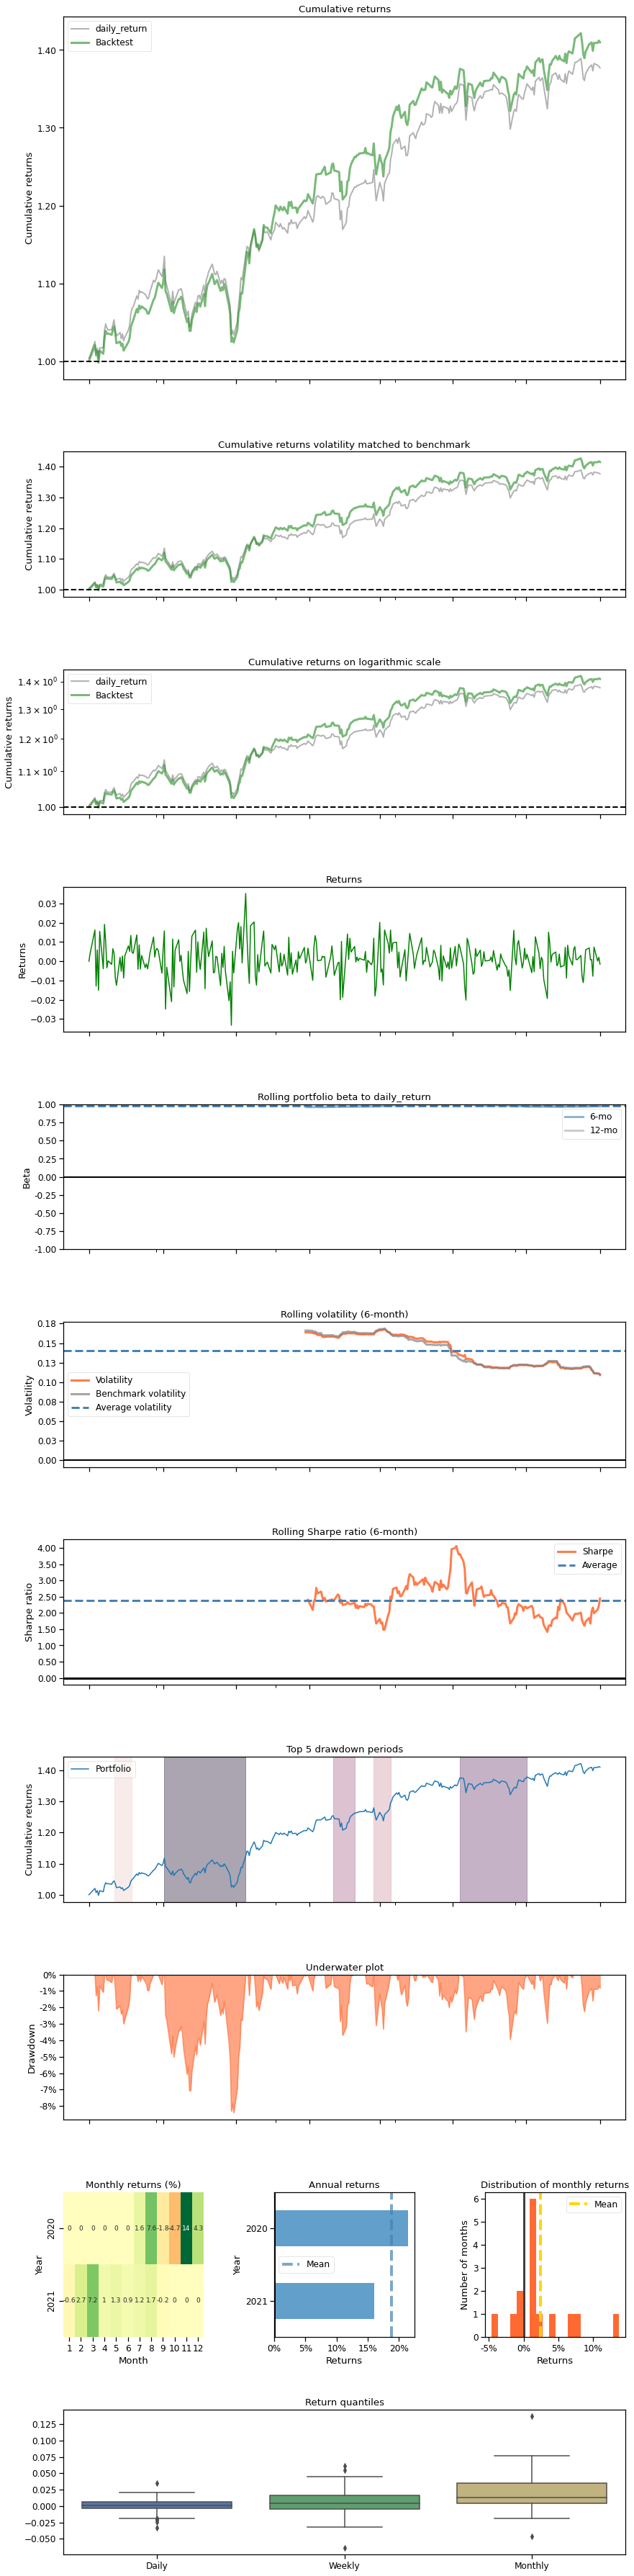

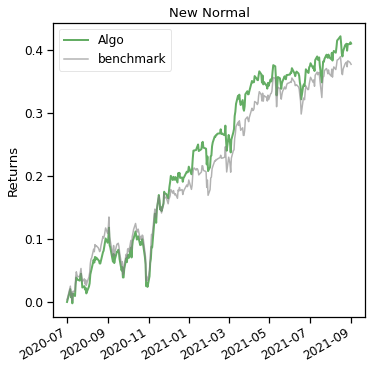

In [34]:
%matplotlib inline
SAC_Agent.plot_backtest_results(df_benchmark_returns=df_DJI_returns)

In [24]:
df_pf_weights_hist.iloc[100:130].plot()

NameError: name 'df_pf_weights_histiloc' is not defined

## SAC - Case(s) 4



**1) Modifying states**

The environment parameters were:

        n_lookback_prds = 90
        pf_value_ini = 1000000
        reward_type=  'portfolio_return' # 'portfolio_return' #'portfolio_value'
        state_struct_list = ['close', 'volume', 'weights', 'returns_cov']
        tech_ind_list = ['turbulence']
        transaction_cost_pct = 0

The agent parameters were:

        SAC_PARAMS = {
            "batch_size": 500,
            "buffer_size": 1000000,
            "learning_rate": 0.0001,
            "ent_coef": 0,
            "gamma":0,
        }
        
Results:

        Annual return	36.4%
        Cumulative returns	44.0%
        Annual volatility	14.5%
        Sharpe ratio	2.22
        
Losses at 20th round:

        | train/             |             |
        |    actor_loss      | 486         |
        |    critic_loss     | 2.09e+05    |
        |    ent_coef        | 0           |
        |    learning_rate   | 0.0001      |
        
**2) Second trial with modded states**

Here the agent params were:

        SAC_PARAMS = {
            "batch_size": 256,
            "buffer_size": 1000000,
            "learning_rate": 0.001,
            "ent_coef": "auto_0.1",
            "gamma":0,
        }
        
Training started with a high Sharpe ratio, but the actor and entropy coefficient losses kept growing until the training crashed:

        ValueError: Expected parameter loc (Tensor of shape (1, 28)) of distribution Normal(loc: torch.Size([1, 28]), scale: torch.Size([1, 28])) to satisfy the constraint Real(), but found invalid values:
        tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                 nan, nan, nan, nan]], device='cuda:0')
                 
**3) Better training**

Used the following agent params:

        SAC_PARAMS = {
            "batch_size": 256,
            "buffer_size": 1000000,
            "learning_rate": 0.001,
            "ent_coef": 0.1,
            "gamma":0,
        }
        
For the first time, the critic loss decreased steadily, and the actor loss stabilized at 58.3. The first SR was 1.0011 and for the remaining rounds it stayed at 0.98.
I don't like the results though:

        Annual return	33.8%
        Cumulative returns	40.8%
        Annual volatility	13.7%
        Sharpe ratio	2.19
        
These results come from the weights taking only 2 values. They're aggregating as before.

**Environments**

In [16]:
# Env params
n_lookback_prds = 90
pf_value_ini = 1000000
reward_type=  'portfolio_return' # 'portfolio_return' #'portfolio_value'
state_struct_list = ['close', 'volume', 'weights', 'returns_cov']
tech_ind_list = ['turbulence']
transaction_cost_pct = 0

In [17]:
gym_train_env = DRL_PFOpt_gymEnv.PortfolioOptEnv(
            df_X = df_train,
            cov_X = cov_X_train,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,)

In [18]:
gym_test_env = DRL_PFOpt_gymEnv.PortfolioOptEnv(
            df_X = df_test,
            cov_X = cov_X_test,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,)

In [19]:
gym_train_env.N_periods

2894

**Model**

In [34]:
del SAC_Agent

In [30]:
# Instantiate agent
SAC_Agent = PFOpt_DRL_Agent(train_env = gym_train_env)

In [31]:

SAC_PARAMS = {
    "batch_size": 256,
    "buffer_size": 1000000,
    "learning_rate": 0.001,
    "ent_coef": 0.001,
    "seed": 0,
    "gamma":0,
}
SAC_Agent.set_model(model_name = "sac",
                    model_kwargs=SAC_PARAMS)
SAC_Agent.train_model(tb_log_name='sac',
                      n_train_rounds=20)

{'batch_size': 256, 'buffer_size': 1000000, 'learning_rate': 0.001, 'ent_coef': 0.1, 'gamma': 0}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
sac with given parameters has been successfully created.
Initial portfolio value: 1000000
End portfolio value: 6612246.729646633
Yearly Sharpe ratio at last period: 1.0011563434940398
Initial portfolio value: 1000000
End portfolio value: 6329529.454152923
Yearly Sharpe ratio at last period: 0.982759951580879
Initial portfolio value: 1000000
End portfolio value: 6329529.454152923
Yearly Sharpe ratio at last period: 0.982759951580879
Initial portfolio value: 1000000
End portfolio value: 6329529.454152923
Yearly Sharpe ratio at last period: 0.982759951580879
------------------------------------
| rollout/           |             |
|    ep_len_mean     | 2.89e+03    |
|    ep_rew_mean     | 2.06        |
| time/              |             |
|    episodes        | 4           |
|    fps             | 4

In [18]:
#SAC_Agent.save_model(model_fname = "trained_models/SAC_OHLCVW_SftMx_SR223_221103224")

Model successfully saved under trained_models/SAC_OHLCVW_SftMx_SR223_221103224.zip


True

In [32]:
df_pf_value_hist, df_pf_return_hist, \
df_pf_weights_hist = SAC_Agent.run_backtest(test_env = gym_test_env,)

Initial portfolio value: 1000000
End portfolio value: 1408345.2985110846
Yearly Sharpe ratio at last period: 2.196490910549994
Finished running backtest. Storing results...


Start date,2020-07-01
End date,2021-09-01
Total months,14
,Backtest
Annual return,33.8%
Cumulative returns,40.8%
Annual volatility,13.7%
Sharpe ratio,2.19
Calmar ratio,4.46
Stability,0.95
Max drawdown,-7.6%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.60,2020-09-02,2020-09-23,2020-11-09,49
1,4.18,2021-06-04,2021-06-18,2021-07-12,27
2,3.53,2021-01-21,2021-01-29,2021-02-08,13
3,3.24,2021-05-07,2021-05-12,2021-06-04,21
4,3.12,2021-02-24,2021-03-04,2021-03-10,11


Stress Events,mean,min,max
New Normal,0.12%,-3.23%,3.19%


True

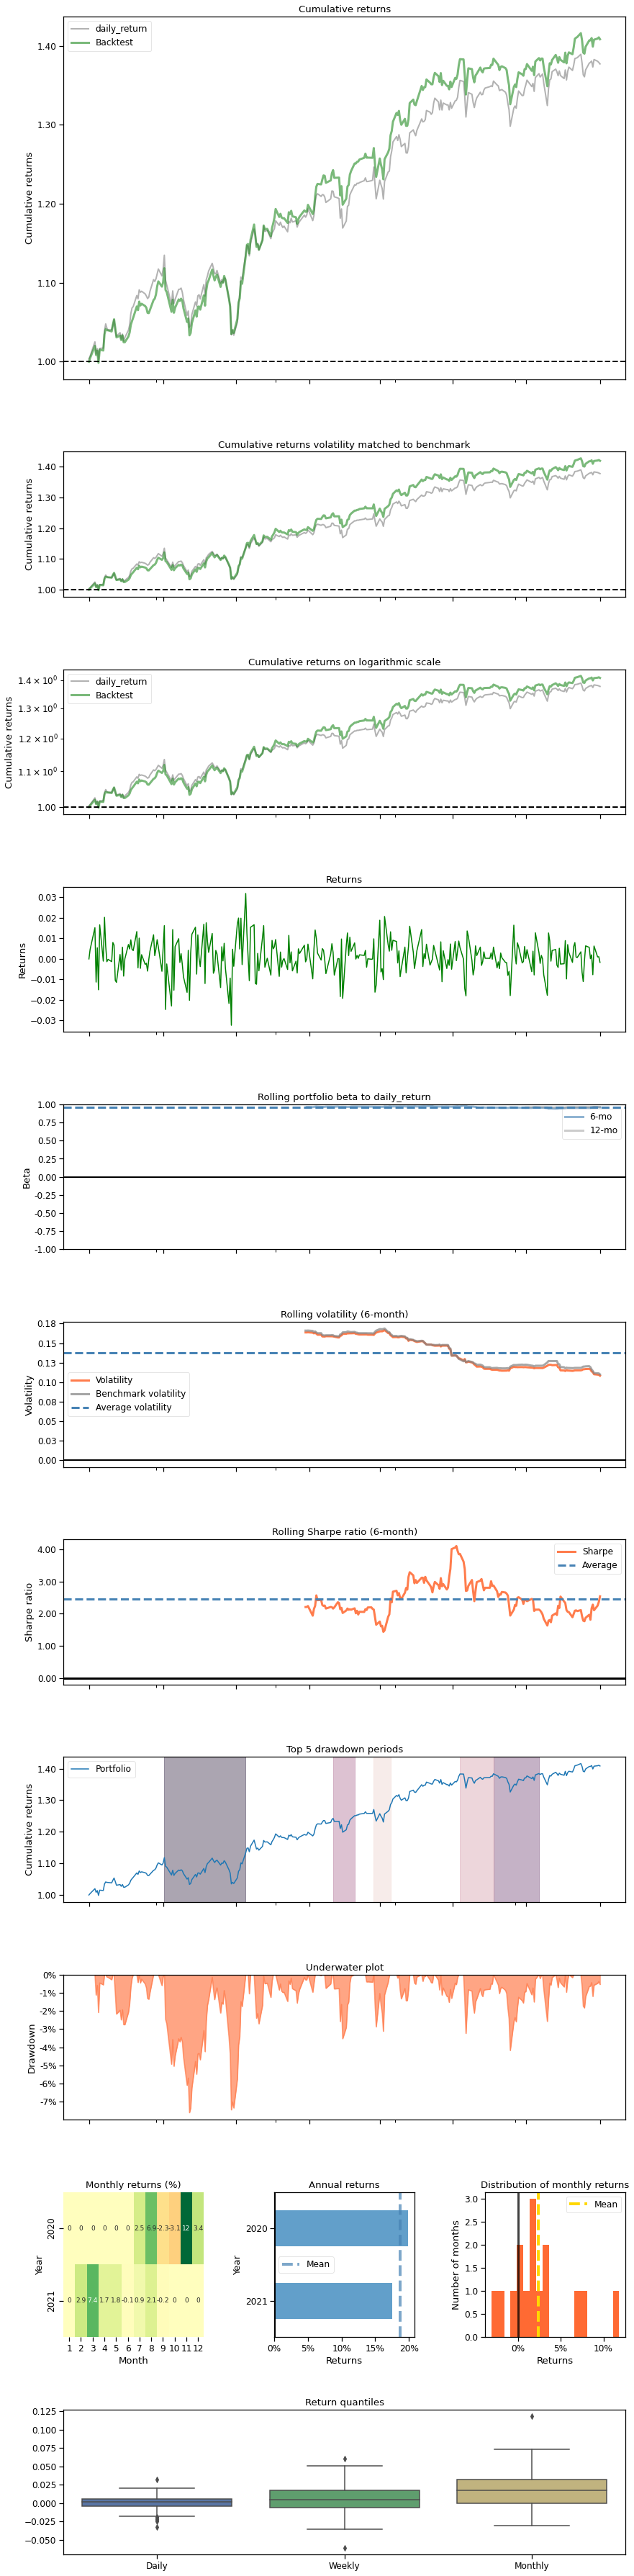

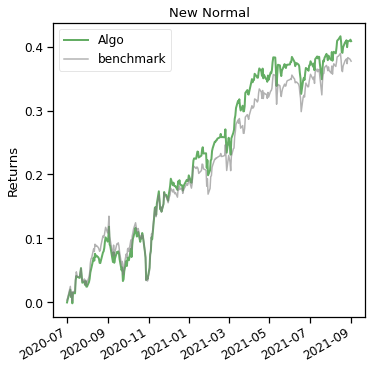

In [33]:
%matplotlib inline
SAC_Agent.plot_backtest_results(df_benchmark_returns=df_DJI_returns)

<AxesSubplot:>

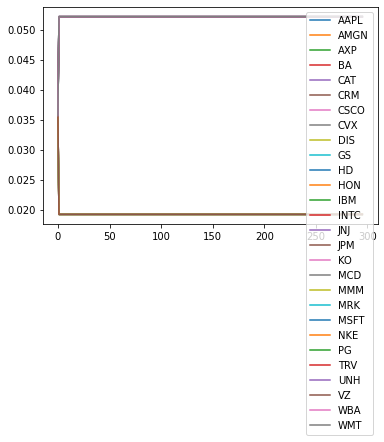

In [35]:
df_pf_weights_hist.plot()

In [ ]:
SAC